In [ ]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from collections import Counter
from audiomentations import Compose, AddGaussianNoise, TimeStretch, Shift, Gain, PolarityInversion

DIVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATCH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATCH / 'morse_dataset'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 64
N_FFT = 512
HOP_LENGTH = 160
TOP_DB = 80
FREQ_MASK = 20
TIME_MASK = 30

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.0002 #2e-4
WEIGHT_DECAY = 0.00001

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'sample_submission.csv'))

all_chars = Counter("".join(train_data['message']))
BLANK_CHAR = "_"
vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
num_classes = len(vocab_list)
char_to_int = {char: i for i, char in enumerate(vocab_list)}
int_to_char = {i: char for i, char in enumerate(vocab_list)}
BLANK_IDX = char_to_int[BLANK_CHAR]

class MosreDataset(Dataset):
    """
    Класс для обработки 
    """
    def __init__(self, df, data_patch,char_to_int, train=True, transforms=None, prev_chars = 1):
        self.df = df
        self.is_train = train

        self.data_path = data_patch
        self.audio_paths = self.data_path / 'morse_dataset'

        self.transforms = transforms

        self.char_to_int = char_to_int
        self.prev_chars = prev_chars

        if self.is_train:
            self.messeges = self.df.message.values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #Получение аугментрованых спектрограмм
        try:
            audio_file = self.audio_paths / self.df.id.values[index]
            waveform, sample_rate = torchaudio.load(audio_file)
            waveform = TRAIN_AUGMENT(waveform)
            augmented_spectrogram = self.transforms(waveform)

            if self.is_train:
                message = self.messeges[index]
                #Получение списка индексов секта - как требует CTC los
                target = torch.tensor([self.char_to_int[char] for char in message], dtype=torch.long); 
                target_len = torch.tensor(len(target), dtype=torch.long)
                return augmented_spectrogram, target, target_len, message
            else:
                return augmented_spectrogram, None, None, None
        except Exception as ex:
            print(str(ex))
        
    def change_time(self, audio_file, max_len = 384000):
        waveform, sample_rate = torchaudio.load(audio_file)
        cahanal, sig_len = waveform.shape

        if sig_len < max_len:
            pad_len = torch.zeros(max_len - sig_len).unsqueeze(0)
            waveform = torch.cat([waveform, pad_len], dim=1)

        return waveform
    
FIRST_FE_COUNT = 16
SECOND_FE_COUNT = 32
THIRD_FE_COUNT = 32
QAD_FE_COUNT = 32
PADDING = 1
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 256

class AttentionDecoder(nn.Module):
    def __init__(self, enc_dim, dec_dim, num_classes):
        super().__init__()
        self.query = nn.Parameter(torch.randn(dec_dim))  # learnable query vector
        self.attn = nn.Linear(enc_dim + dec_dim, dec_dim)
        self.v = nn.Parameter(torch.rand(dec_dim))
        self.proj = nn.Linear(enc_dim, num_classes)

    def forward(self, enc_outputs):
        # enc_outputs: [B, T, enc_dim]
        B, T, D = enc_outputs.size()
        queries = self.query.unsqueeze(0).expand(B, -1)  # [B, D_dec]
        scores = torch.tanh(self.attn(torch.cat([
            enc_outputs,
            queries.unsqueeze(1).expand(-1, T, -1)
        ], dim=-1)))  # [B, T, dec_dim]
        scores = torch.matmul(scores, self.v)  # [B, T]
        attn_weights = F.softmax(scores, dim=1).unsqueeze(-1)  # [B, T,1]
        context = (enc_outputs * attn_weights).sum(dim=1)  # [B, enc_dim]
        logits = self.proj(context)  # [B, num_classes]
        # replicate logits over time for CTC
        return logits.unsqueeze(1).expand(-1, T, -1).permute(1,0,2)  # [T, B, C]
    
class MorseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        chan1 = FIRST_FE_COUNT
        chan2 = chan1 * 2
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=chan1, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(chan1),
            nn.GELU(),
            nn.MaxPool2d((1, 2), (1, 2)), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=chan1, 
                      out_channels=chan1, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(chan1),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=chan1, 
                      out_channels=chan2, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(chan2),
            nn.GELU(),
            nn.MaxPool2d((2, 2), (2, 2)), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=chan2, 
                      out_channels=chan2, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(chan2),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)) # [batch=32, QAD_FE_COUNT = 32, 8, 80](что юы сохраниить большще признаков по горизонтали)
        )

        with torch.no_grad():
            dummy = torch.randn(1,1,N_MELS, 356)
            out = self.net_conv(dummy)
            self.cnn_output_features = out.numel()//out.shape[0]//out.shape[-2]  # channels * mels

        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2); 
        self.gelu = nn.GELU()

        self.embed_dim = GRU_HIDEN * 2
        self.rnn = nn.LSTM(
                input_size=N_MELS*2,
                hidden_size=GRU_HIDEN,
                num_layers=2,
                bidirectional=True,
                dropout=0.3,
                batch_first=True 
            )
        self.attention = nn.MultiheadAttention(
            embed_dim=self.embed_dim,
            num_heads=8,
            dropout=0.3,
            batch_first=True
        )
        
        self.layer_norm = nn.LayerNorm(self.embed_dim)    
        self.attn_dec = AttentionDecoder(enc_dim=self.embed_dim, dec_dim=self.embed_dim, num_classes=num_classes)  
        self.layer2 = nn.Linear(self.embed_dim, num_classes)       

    def forward(self, x):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]

        # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # собой объединение столбцов всех карт. 
        # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=32, seq_len=89, features/hiden_dim=512]
        x = self.layer1(x)
        x = self.gelu(x)

        self.rnn.flatten_parameters()

        x = self.rnn(x) # [batch=32, seq_len=89, features/hiden_dim=256 * 2]
        x, _ = x # берем информацию со всез состояний
        # Типо Self-attention
        x = self.layer_norm(x)
        x = self.layer_norm(x + attn_output)  
        # x = self.dropout(x)
        x = self.layer2(x) # logits - [batch, sequence, num_classes] 
        x = nn.functional.log_softmax(x.permute(1,0,2), dim=2) # pertime так как CTC loss требует на взод (sequence/T,batch/N,num_classes/C)
        '''
        по одному прогнозу для каждого из признаков в последовательности, 
        в итоге получается 89 прогнозов символов для каждой секунды звука.
        '''
        return x
    
TRAIN_AUGMENT = Compose([
    AddGaussianNoise(min_amplitude=1e-4, max_amplitude=0.02, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.4),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.3),
    Gain(-12, 12, p=0.5),  # <-- исправлено
    PolarityInversion(p=0.2)
])

train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK),
    transforms.TimeMasking(time_mask_param=TIME_MASK),
    # v2.RandomCrop((N_MELS, 1920)) # Обрезает последний кадр спектрограммы, в идеале надобы считать а не прописывать число
    ) # заметка - Данные трансформации не создают довых обучаемых параметров. Но есть и те что создают. В будущем это стоит учитывать

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    # v2.CenterCrop((N_MELS, 1920)) 
    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.15, random_state=SEED)

train_ds = MosreDataset(df=train_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=train_audio_transforms)

val_ds = MosreDataset(df=val_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=valid_audio_transforms)


def my_collate(batch):
    '''
    При обработке dataloader labels будут 
    выравниваться по макс длине для выравнивания батча
    Т.е. будет padding . что в будующем будет пустым значением для ctc loss
    '''
    spectrograms = [item[0].squeeze(0) for item in batch]
    # Падинг спектрограмм по максимальной длине
    spectrograms_permuted = [s.permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)

    if batch[0][3] is not None:
        target = torch.nn.utils.rnn.pad_sequence(
                                                [item[1] for item in batch], 
                                                batch_first=True, 
                                                padding_value=BLANK_IDX)# выравнивает последовательность до макс 
                                                                        # длины в батче заполняя пропуски нулем
        label_len = torch.stack([item[2] for item in batch])
        msg = [item[3] for item in batch]
        
        return [spectrograms_padded, target, label_len, msg]
    else: 
        return spectrograms_padded

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate, drop_last=True)

test, test_target, _, mess = next(iter(train_dl))
test, test_target= test.to(DIVICE), test_target.to(DIVICE)

test_val, val_target, __, val_mess = next(iter(val_dl))
test_val, val_target = test_val.to(DIVICE), val_target.to(DIVICE)
# test.shape 

#===== начало обучения =====
model = MorseNet(num_classes=num_classes).to(DIVICE)
# model = DataParallel(model)
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)  # Было 0.002
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
loss_func = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(DIVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMorseNet - инициалицация модели. Число обучаемых параметров: {total_params:,}")

Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional argument: 'sample_rate'
Compose.__call__() missing 1 required positional ar

TypeError: 'NoneType' object is not subscriptable

# Обучение модели

In [2]:
import Levenshtein
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds


In [ ]:
lst_loss_train = []
lst_loss_val = []
best_val_loss = 0
for epoch in range(EPOCHS):
    model.train()

    epoch_train_loss = 0.0
    train_predicts = []

    train_tqdm = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for batch_ind, batch in enumerate(train_tqdm):
        mel_spec, targets, targets_lens, _ = batch
        mel_spec, targets, targets_lens = mel_spec.to(DIVICE), targets.to(DIVICE), targets_lens.to(DIVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====
        
        optimizer.zero_grad()
        predict = model(mel_spec) # (N=batch,T,C)
        N = predict.shape[1]
        T = predict.shape[0]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

        try:
            loss = loss_func(predict, targets, predict_lengths, targets_lens.reshape(BATCH_SIZE))
        except RuntimeError:
            print(predict.shape, targets.shape, predict_lengths, targets_lens.reshape(BATCH_SIZE))
            continue
        # print(loss)
        if torch.isnan(loss) or torch.isinf(loss): 
            print(f"\nWarning: In batch-{batch_ind} loss train is NaN/Inf: {loss.item()}"); 
            optimizer.zero_grad(); 
            continue

        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()

    train_loss = epoch_train_loss / len(train_dl)

    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    total_val = 0
    val_predicts = []

    with torch.no_grad():
        for val_mel_spec, val_labels, val_label_lensin, _ in tqdm(
                                                        val_dl, 
                                                        desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", 
                                                        leave=False):
            val_mel_spec, val_labels, val_label_lensin = val_mel_spec.to(DIVICE), val_labels.to(DIVICE), val_label_lensin.to(DIVICE)
            val_predict = model(val_mel_spec)

            val_N = val_predict.shape[1]
            val_T = val_predict.shape[0]
            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            val_loss += loss_func(val_predict, val_labels, predict_val_lengths, val_label_lensin).item()

    total_val = val_loss / len(val_dl)

    lst_loss_train.append(train_loss)
    lst_loss_val.append(total_val)

    scheduler.step(total_val)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Новая лучшая модель сохранена с val_loss: {val_loss:.4f}")
    

    print(f"\n===== Эпоха {epoch+1}/{EPOCHS} =====")\
    #===== Инфо про градиенты=====
    grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    if grad_norms:
        print(f"Mean grad norm: {np.mean(grad_norms):.6f}")
        print(f"Max grad norm: {np.max(grad_norms):.6f}")
        print(f"Min grad norm: {np.min(grad_norms):.6f}")
    else:
        print("No gradients computed yet.")
    #===== Инфо про шаг обучения и данные по потерям =====
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.6f}")
    print(f"---- Train Loss: {train_loss:.4f}")
    print(f"---- Val Loss: {total_val:.4f}")
    if current_lr <= 1e-6:
        print("Learning rate достиг минимума 1e-6, остановка обучения")
        break
    print("-" * 50)


===== Эпоха 1/50 =====
Mean grad norm: 0.096066
Max grad norm: 1.586106
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 4.1781
---- Val Loss: 4.1766
--------------------------------------------------



===== Эпоха 2/50 =====
Mean grad norm: 0.071237
Max grad norm: 1.064341
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 4.0223
---- Val Loss: 4.1563
--------------------------------------------------



===== Эпоха 3/50 =====
Mean grad norm: 0.142785
Max grad norm: 1.672672
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 4.0185
---- Val Loss: 4.0694
--------------------------------------------------



===== Эпоха 4/50 =====
Mean grad norm: 0.303648
Max grad norm: 1.899392
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 3.1852
---- Val Loss: 1.1023
--------------------------------------------------



===== Эпоха 5/50 =====
Mean grad norm: 0.371700
Max grad norm: 2.357514
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 1.0981
---- Val Loss: 0.4965
--------------------------------------------------



===== Эпоха 6/50 =====
Mean grad norm: 0.316188
Max grad norm: 2.500651
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.7904
---- Val Loss: 0.4667
--------------------------------------------------



===== Эпоха 7/50 =====
Mean grad norm: 0.305953
Max grad norm: 2.259201
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.6729
---- Val Loss: 0.3408
--------------------------------------------------



===== Эпоха 8/50 =====
Mean grad norm: 0.339325
Max grad norm: 3.109261
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.6079
---- Val Loss: 0.2944
--------------------------------------------------



===== Эпоха 9/50 =====
Mean grad norm: 0.274479
Max grad norm: 2.184908
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5646
---- Val Loss: 0.2567
--------------------------------------------------



===== Эпоха 10/50 =====
Mean grad norm: 0.502051
Max grad norm: 4.358695
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5371
---- Val Loss: 0.2498
--------------------------------------------------



===== Эпоха 11/50 =====
Mean grad norm: 0.389562
Max grad norm: 3.417289
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.5094
---- Val Loss: 0.2903
--------------------------------------------------



===== Эпоха 12/50 =====
Mean grad norm: 0.332673
Max grad norm: 2.586166
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4947
---- Val Loss: 0.2232
--------------------------------------------------



===== Эпоха 13/50 =====
Mean grad norm: 0.256282
Max grad norm: 2.063805
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4768
---- Val Loss: 0.2273
--------------------------------------------------



===== Эпоха 14/50 =====
Mean grad norm: 0.337266
Max grad norm: 2.749291
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4658
---- Val Loss: 0.2212
--------------------------------------------------



===== Эпоха 15/50 =====
Mean grad norm: 0.241152
Max grad norm: 2.052337
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4542
---- Val Loss: 0.2143
--------------------------------------------------



===== Эпоха 16/50 =====
Mean grad norm: 0.441269
Max grad norm: 3.463967
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4415
---- Val Loss: 0.2030
--------------------------------------------------



===== Эпоха 17/50 =====
Mean grad norm: 0.177875
Max grad norm: 1.459275
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4342
---- Val Loss: 0.2009
--------------------------------------------------



===== Эпоха 18/50 =====
Mean grad norm: 0.343056
Max grad norm: 3.269634
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4318
---- Val Loss: 0.2125
--------------------------------------------------



===== Эпоха 19/50 =====
Mean grad norm: 0.321616
Max grad norm: 2.408809
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4250
---- Val Loss: 0.2083
--------------------------------------------------



===== Эпоха 20/50 =====
Mean grad norm: 0.419765
Max grad norm: 3.468226
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4168
---- Val Loss: 0.1835
--------------------------------------------------



===== Эпоха 21/50 =====
Mean grad norm: 0.388706
Max grad norm: 3.243846
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4179
---- Val Loss: 0.2376
--------------------------------------------------



===== Эпоха 22/50 =====
Mean grad norm: 0.717784
Max grad norm: 5.267270
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4109
---- Val Loss: 0.2097
--------------------------------------------------



===== Эпоха 23/50 =====
Mean grad norm: 0.261019
Max grad norm: 1.882429
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4038
---- Val Loss: 0.1820
--------------------------------------------------



===== Эпоха 24/50 =====
Mean grad norm: 0.179867
Max grad norm: 1.305564
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.4031
---- Val Loss: 0.1781
--------------------------------------------------



===== Эпоха 25/50 =====
Mean grad norm: 0.248724
Max grad norm: 1.615864
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.3953
---- Val Loss: 0.1858
--------------------------------------------------



===== Эпоха 26/50 =====
Mean grad norm: 0.175271
Max grad norm: 1.250558
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.3926
---- Val Loss: 0.1904
--------------------------------------------------



===== Эпоха 27/50 =====
Mean grad norm: 0.242282
Max grad norm: 1.855692
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.3914
---- Val Loss: 0.1959
--------------------------------------------------



===== Эпоха 28/50 =====
Mean grad norm: 0.145248
Max grad norm: 0.857805
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.3807
---- Val Loss: 0.1732
--------------------------------------------------



===== Эпоха 29/50 =====
Mean grad norm: 0.328976
Max grad norm: 3.332460
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.3820
---- Val Loss: 0.1722
--------------------------------------------------



===== Эпоха 30/50 =====
Mean grad norm: 0.266405
Max grad norm: 2.250565
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.3833
---- Val Loss: 0.1750
--------------------------------------------------



===== Эпоха 31/50 =====
Mean grad norm: 0.301770
Max grad norm: 2.087591
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.3779
---- Val Loss: 0.2087
--------------------------------------------------



===== Эпоха 32/50 =====
Mean grad norm: 0.389465
Max grad norm: 2.822993
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.3738
---- Val Loss: 0.1716
--------------------------------------------------



===== Эпоха 33/50 =====
Mean grad norm: 0.183932
Max grad norm: 1.152354
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.3686
---- Val Loss: 0.1630
--------------------------------------------------



===== Эпоха 34/50 =====
Mean grad norm: 0.207592
Max grad norm: 1.497677
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.3641
---- Val Loss: 0.1802
--------------------------------------------------



===== Эпоха 35/50 =====
Mean grad norm: 0.317820
Max grad norm: 2.629927
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.3584
---- Val Loss: 0.1792
--------------------------------------------------



===== Эпоха 36/50 =====
Mean grad norm: 0.267309
Max grad norm: 2.092673
Min grad norm: 0.000000
Current LR: 0.000200
---- Train Loss: 0.3718
---- Val Loss: 0.1727
--------------------------------------------------



===== Эпоха 37/50 =====
Mean grad norm: 0.258507
Max grad norm: 2.207173
Min grad norm: 0.000000
Current LR: 0.000100
---- Train Loss: 0.3607
---- Val Loss: 0.1879
--------------------------------------------------



===== Эпоха 38/50 =====
Mean grad norm: 0.164192
Max grad norm: 0.997189
Min grad norm: 0.000000
Current LR: 0.000100
---- Train Loss: 0.3446
---- Val Loss: 0.1626
--------------------------------------------------



===== Эпоха 39/50 =====
Mean grad norm: 0.128998
Max grad norm: 0.948456
Min grad norm: 0.000000
Current LR: 0.000100
---- Train Loss: 0.3310
---- Val Loss: 0.1550
--------------------------------------------------



===== Эпоха 40/50 =====
Mean grad norm: 0.127667
Max grad norm: 1.061912
Min grad norm: 0.000000
Current LR: 0.000100
---- Train Loss: 0.3261
---- Val Loss: 0.1627
--------------------------------------------------



===== Эпоха 41/50 =====
Mean grad norm: 0.136888
Max grad norm: 1.244545
Min grad norm: 0.000000
Current LR: 0.000100
---- Train Loss: 0.3248
---- Val Loss: 0.1587
--------------------------------------------------



===== Эпоха 42/50 =====
Mean grad norm: 0.154719
Max grad norm: 1.031763
Min grad norm: 0.000000
Current LR: 0.000100
---- Train Loss: 0.3256
---- Val Loss: 0.1579
--------------------------------------------------



===== Эпоха 43/50 =====
Mean grad norm: 0.321592
Max grad norm: 2.442849
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3243
---- Val Loss: 0.1579
--------------------------------------------------



===== Эпоха 44/50 =====
Mean grad norm: 0.615070
Max grad norm: 5.421957
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3129
---- Val Loss: 0.1534
--------------------------------------------------



===== Эпоха 45/50 =====
Mean grad norm: 0.763766
Max grad norm: 7.983343
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3086
---- Val Loss: 0.1522
--------------------------------------------------



===== Эпоха 46/50 =====
Mean grad norm: 0.136167
Max grad norm: 1.064135
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3068
---- Val Loss: 0.1536
--------------------------------------------------



===== Эпоха 47/50 =====
Mean grad norm: 0.303000
Max grad norm: 2.364297
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3073
---- Val Loss: 0.1510
--------------------------------------------------



===== Эпоха 48/50 =====
Mean grad norm: 0.368863
Max grad norm: 2.470103
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3016
---- Val Loss: 0.1514
--------------------------------------------------



===== Эпоха 49/50 =====
Mean grad norm: 0.155270
Max grad norm: 1.328383
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.2972
---- Val Loss: 0.1526
--------------------------------------------------



===== Эпоха 50/50 =====
Mean grad norm: 0.369572
Max grad norm: 3.702634
Min grad norm: 0.000000
Current LR: 0.000050
---- Train Loss: 0.3023
---- Val Loss: 0.1509
--------------------------------------------------


In [7]:
torch.save(model.state_dict(), 'MorseNet.pth')

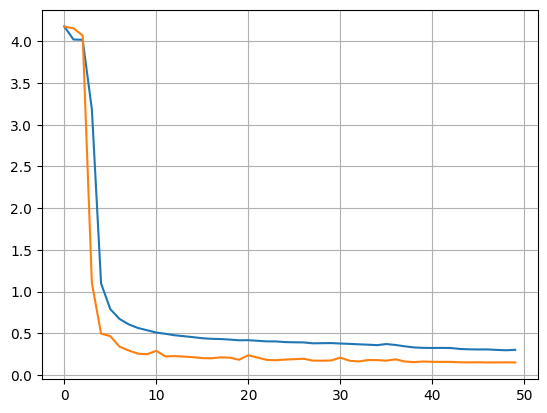

In [3]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()

In [11]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes)
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

with torch.no_grad():
    train_mess = []
    train_predicts = []
    for loader in train_dl:
        seq, test_target, _, mess = loader
        train_mess.extend(mess)

        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        train_predicts.extend(predicted_values)

    val_mess = []
    val_predicts = []
    for loader in val_dl:
        seq, test_target, _, mess = loader
        val_mess.extend(mess)

        logits= model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        val_predicts.extend(predicted_values)

import Levenshtein

mean_acc_test = np.mean([Levenshtein.ratio(test_pred, train_mess[ind]) for ind, test_pred in enumerate(train_predicts)])
mean_acc_val = np.mean([Levenshtein.ratio(val_pred, val_mess[ind]) for ind, val_pred in enumerate(val_predicts)])


print(f"Mean accurasu by The Levenshtein in train is : {mean_acc_test}")
print(f"Mean accurasu by The Levenshtein in validate is : {mean_acc_val}")

CNN размерность выхода: torch.Size([1, 32, 8, 89])
CNN число фичей: 256
Mean accurasu by The Levenshtein in train is : 0.8834991353129507
Mean accurasu by The Levenshtein in validate is : 0.9265079209781295


# Сбор sample_submission

In [12]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes)
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

test_ds = MosreDataset(df=sample_data,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=False,
                        transforms=valid_audio_transforms)


test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, shuffle=False, collate_fn=my_collate)
model_load.eval()

with torch.no_grad():
    test_predicts = []
    for loader in test_dl:
        seq = loader
        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        test_predicts.extend(predicted_values)

sample_data.message = test_predicts
sample_data.to_csv('sample_submission.csv', index=False)

CNN размерность выхода: torch.Size([1, 32, 8, 89])
CNN число фичей: 256
